In [1]:
import sys
sys.path.append('/home/jovyan/workspace')

In [2]:
# %%sh
# rm -rf '../data/test'

In [3]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

In [4]:
system = planetengine.systems.arrhenius.build(res = 64)
initials = {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)}
planetengine.initials.apply(
    initials,
    system,
    )
system.solve()

In [5]:
variable1 = pfn.convert(system.velocityField, 'velocity')
variable2 = pfn.convert(system.temperatureField, 'temperature')
constant = pfn.convert(2.)
shape = pfn.convert(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))
vanilla = pfn.convert(system.viscosityFn, 'viscosity')

In [6]:
# def makevar():
#     var = variable1
#     var = pfn.Region(var, shape)
#     var = pfn.Component.rad(var)
#     var = pfn.Gradient.mag(var)
#     var = pfn.Quantiles.median(var)
#     var = pfn.Filter(var, 1.)
#     var = pfn.Gradient.rad(var)
#     var = pfn.Normalise(var, [0., 1.])
#     var = pfn.Binarise(var)
#     var = var * vanilla
#     var = var ** constant
#     var = var * variable2
#     var = pfn.HandleNaN.zero(var)
#     var = pfn.Normalise(var, [0., 1.])
#     return var

In [48]:
def makevar():
    var = variable2
    var = pfn.Gradient.mag(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Normalise(var, [0., 1.])
    return var

In [49]:
print(round(timeit(makevar, number = 3) / 3, 3))

3.469


In [50]:
var = makevar()

Fitted 1 variables to the figure.
Normalise{Component_component=mag{Gradient{Component_component=mag{Gradient{Component_component=mag{Gradient{Component_component=mag{Gradient{Component_component=mag{Gradient{Component_component=mag{Gradient{Variable_varName=temperature{}}}}}}}}}}}}};Constant_val=arr{[ 0.  1.]}{}}



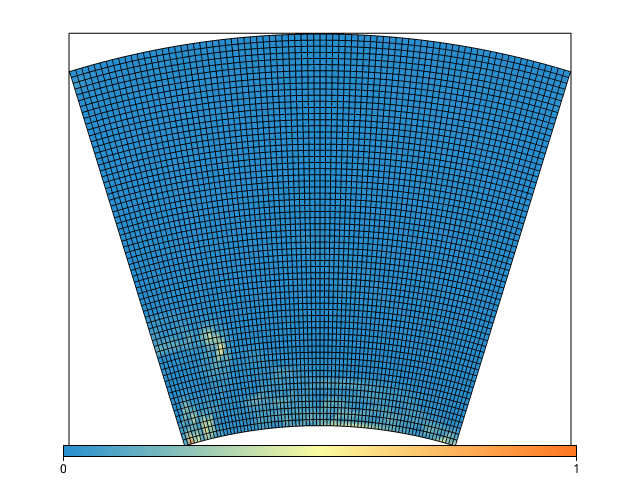

In [51]:
planetengine.quickShow(var.mesh, var)

In [52]:
def testfn(var, timings = '', layer = 1):
    def outer_timefn(var, timinglist = []):
        planetengine.initials.apply(
            initials,
            system,
            )
        var.update()
        system.iterate()
        timing = timeit(var.update, number = 1)
        timinglist.append(timing)
        return timinglist
    var_timings = []
    for i in range(3):
        var_timings = outer_timefn(var, var_timings)
    var_timing = sum(var_timings) / len(var_timings)
    var_timing = round(var_timing, 6)
    timings += '\n'
    newrow = ''
    newrow += layer * '-' + ' '
    newrow += var.opTag
    newrow += ': '
    newrow += '.' * (56 - len(newrow)) + ' '
    newrow += str(var_timing)
    timings += newrow
    for inVar in var.inVars:
        timings = testfn(inVar, timings, layer + 1)
    return timings

In [53]:
timings = testfn(var)

In [54]:
print(timings)


- Normalise: ........................................... 0.35663
-- Component_component=mag: ............................ 0.218004
--- Gradient: .......................................... 0.172679
---- Component_component=mag: .......................... 0.130542
----- Gradient: ........................................ 0.182111
------ Component_component=mag: ........................ 0.134963
------- Gradient: ...................................... 0.082859
-------- Component_component=mag: ...................... 0.078378
--------- Gradient: .................................... 0.062798
---------- Component_component=mag: .................... 0.038798
----------- Gradient: .................................. 0.033694
------------ Component_component=mag: .................. 0.020289
------------- Gradient: ................................ 0.008874
-------------- Variable_varName=temperature: ........... 0.000745
-- Constant_val=arr{[ 0.  1.]}: ........................ 6.8e-05


In [61]:
print(timeit(var._update_summary_stats, number = 1))

0.022531899994646665


In [55]:
red = pfn.Integral(var)

In [56]:
planetengine.initials.apply(
    initials,
    system,
    )
red.update()
system.iterate()
print(red.evaluate())
print(red.evaluate())
system.iterate()
print(red.evaluate())
print(red.evaluate())

[[ 0.00119845]]
[[ 0.00119845]]
[[ 0.00184514]]
[[ 0.00184514]]


In [57]:
def testfn():
    freshsteps = []
    stalesteps = []
    for i in range(3):
        planetengine.initials.apply(
            initials,
            system,
            )
        red.update
        system.iterate()
        freshsteps.append(timeit(red.update, number = 1))
    for i in range(3):
        stalesteps.append(timeit(red.update, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 5)
    average_stale = round(sum(stalesteps) / len(stalesteps), 5)
    ratio = round(average_fresh / average_stale, 5)
    return(average_fresh, average_stale, ratio)
print(testfn())

(0.33081, 0.00142, 232.96479)
